********************************************************************************
For real data, please install OpenBB: pip install openbb
And ensure a compatible Python environment (e.g., 3.9-3.11).
********************************************************************************

--- 1. Strategy: Bollinger Band Mean Reversion ---

Hypothesis: Asset prices exhibit mean-reverting behavior. When prices move significantly
away from their central tendency (represented by a moving average), they are likely to
revert. Bollinger Bands, set at N standard deviations above and below a moving average,
can identify such overbought (above upper band) or oversold (below lower band) conditions.
This strategy will:
- BUY when the price touches or crosses below the lower Bollinger Band.
- SELL (close long position) when the price touches or crosses above the middle band (SMA).
- Optional: SHORT when price touches or crosses above upper band, cover when it hits middle band.
  (This example will focus on 

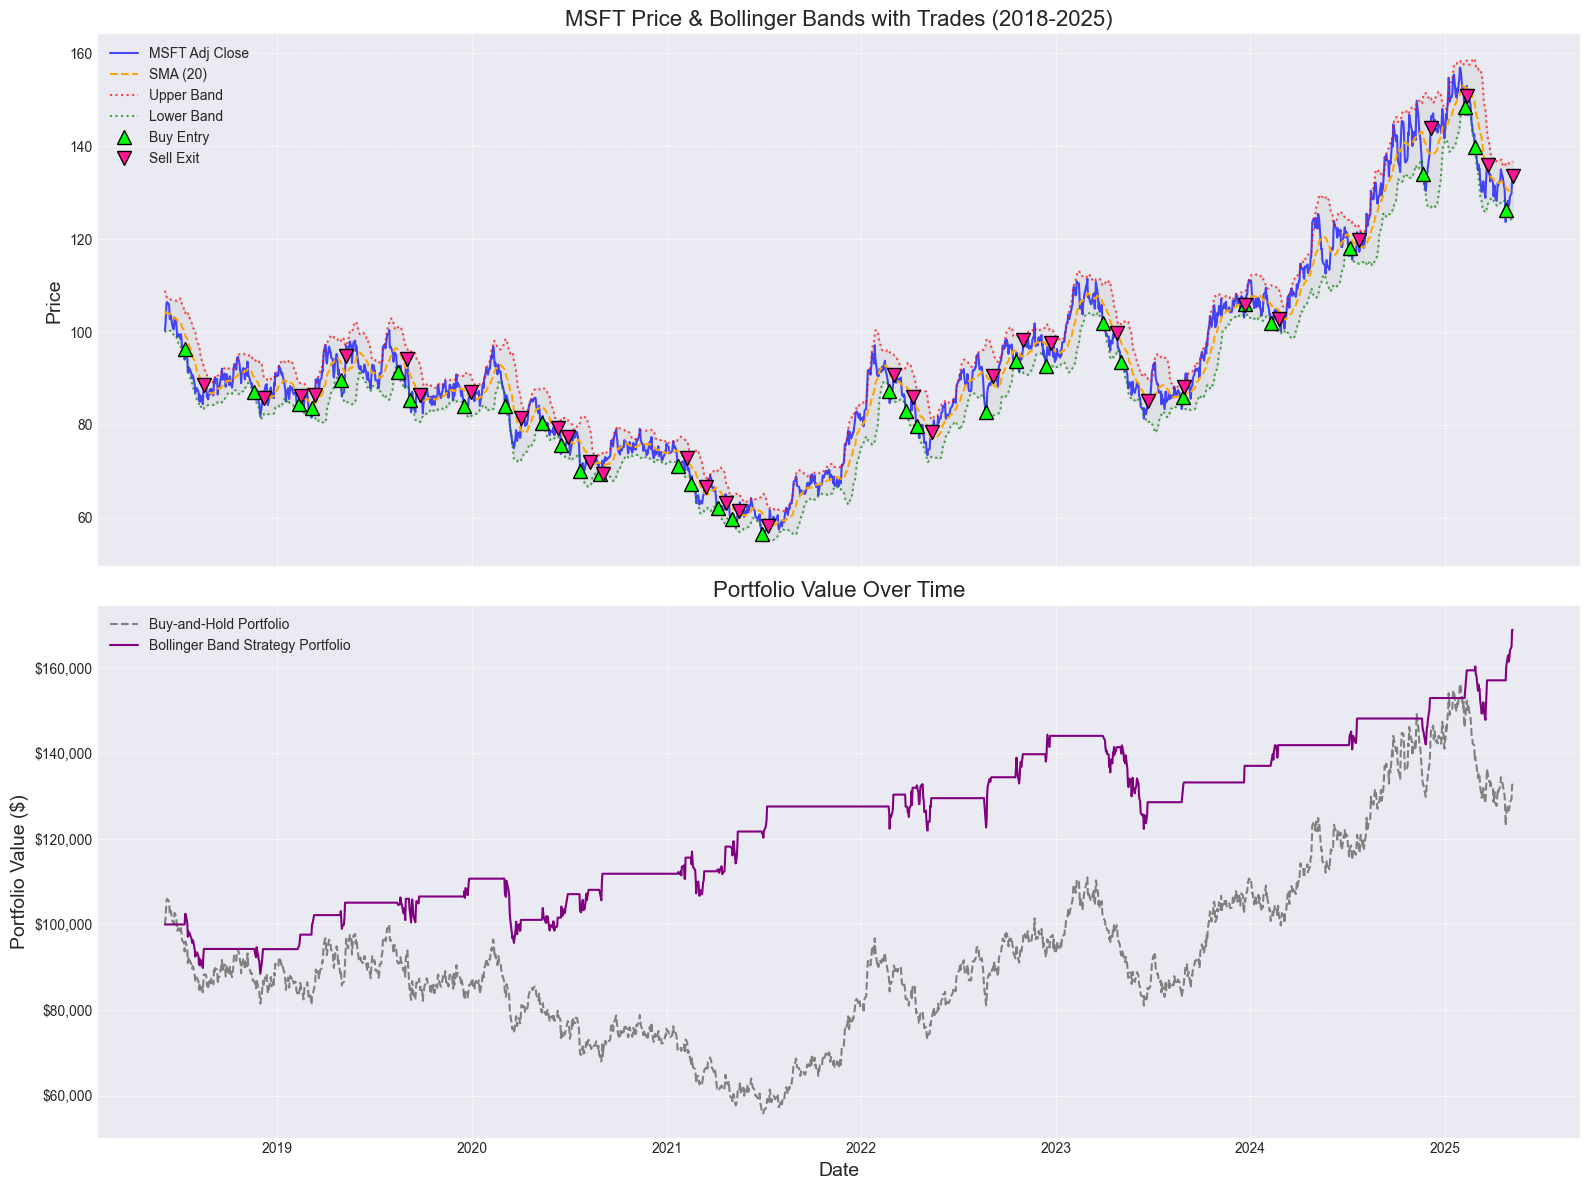


--- 8. Hypothesis Testing (Qualitative Conclusion) ---
Recall Strategy Thesis:

Hypothesis: Asset prices exhibit mean-reverting behavior. When prices move significantly
away from their central tendency (represented by a moving average), they are likely to
revert. Bollinger Bands, set at N standard deviations above and below a moving average,
can identify such overbought (above upper band) or oversold (below lower band) conditions.
This strategy will:
- BUY when the price touches or crosses below the lower Bollinger Band.
- SELL (close long position) when the price touches or crosses above the middle band (SMA).
- Optional: SHORT when price touches or crosses above upper band, cover when it hits middle band.
  (This example will focus on the long-only version for simplicity first).


Observations vs. Buy-and-Hold:
- Strategy CAGR (7.86%) was HIGHER than Buy-and-Hold (4.21%).
- Strategy Sharpe Ratio (0.51) was BETTER than Buy-and-Hold (0.20).
- Strategy Max Drawdown (-15.27%) was SMALLE

In [1]:
# --- 0. IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# Attempt to import OpenBB SDK for data - you can replace this with any data source
try:
    from openbb_terminal.sdk import openbb
    OPENBB_AVAILABLE = True
    print("OpenBB SDK imported successfully.")
except ImportError:
    OPENBB_AVAILABLE = False
    print("********************************************************************************")
    print("WARNING: OpenBB SDK not found. This script will try to use a MOCK DATA function.")
    print("For real data, please install OpenBB: pip install openbb")
    print("And ensure a compatible Python environment (e.g., 3.9-3.11).")
    print("********************************************************************************")

# --- 1. STRATEGY PARAMETERS & THESIS ---
print("\n--- 1. Strategy: Bollinger Band Mean Reversion ---")
STRATEGY_THESIS = """
Hypothesis: Asset prices exhibit mean-reverting behavior. When prices move significantly
away from their central tendency (represented by a moving average), they are likely to
revert. Bollinger Bands, set at N standard deviations above and below a moving average,
can identify such overbought (above upper band) or oversold (below lower band) conditions.
This strategy will:
- BUY when the price touches or crosses below the lower Bollinger Band.
- SELL (close long position) when the price touches or crosses above the middle band (SMA).
- Optional: SHORT when price touches or crosses above upper band, cover when it hits middle band.
  (This example will focus on the long-only version for simplicity first).
"""
print(STRATEGY_THESIS)

# Strategy Parameters
TICKER = "MSFT"  # Example: Microsoft. Use "INFY.NS" for Infosys, "RELIANCE.NS", etc.
# Dynamic Dates for approximately the last 5-10 years
END_DATE_DT = datetime.today()
START_DATE_DT = END_DATE_DT - timedelta(days=7 * 365.25) # Approx 7 years

END_DATE_STR = END_DATE_DT.strftime('%Y-%m-%d')
START_DATE_STR = START_DATE_DT.strftime('%Y-%m-%d')

BB_WINDOW = 20       # Moving average window for Bollinger Bands
BB_NUM_STD_DEV = 2   # Number of standard deviations for upper/lower bands
INITIAL_CAPITAL = 100000.0
RISK_FREE_RATE_ANNUAL = 0.02 # For Sharpe Ratio

print(f"\nTarget Ticker: {TICKER}")
print(f"Approximate Test Period: {START_DATE_STR} to {END_DATE_STR}")
print(f"Bollinger Band Window: {BB_WINDOW}, Std Devs: {BB_NUM_STD_DEV}")
print(f"Initial Capital: ${INITIAL_CAPITAL:,.2f}")

# --- MOCK DATA FUNCTION (if OpenBB is not available) ---
def get_mock_data(ticker, start_date, end_date):
    print(f"--- MOCKING DATA for {ticker} from {start_date} to {end_date} ---")
    date_rng = pd.date_range(start=start_date, end=end_date, freq='B')
    if date_rng.empty:
        return pd.DataFrame()
    
    # Simulate somewhat realistic price movements
    n_points = len(date_rng)
    price = np.zeros(n_points)
    price[0] = np.random.uniform(50, 200) # Random start price
    returns = np.random.normal(loc=0.0005, scale=0.015, size=n_points -1) # Daily returns
    for i in range(1, n_points):
        price[i] = price[i-1] * (1 + returns[i-1])
        if price[i] <= 0: price[i] = price[i-1] # Prevent negative prices

    mock_df = pd.DataFrame(price, index=date_rng, columns=['Adj Close'])
    mock_df['Open'] = mock_df['Adj Close'] * np.random.uniform(0.99, 1.01, size=n_points)
    mock_df['High'] = mock_df[['Open', 'Adj Close']].max(axis=1) * np.random.uniform(1, 1.02, size=n_points)
    mock_df['Low'] = mock_df[['Open', 'Adj Close']].min(axis=1) * np.random.uniform(0.98, 1, size=n_points)
    mock_df['Close'] = mock_df['Adj Close'] # Assuming Adj Close is the close for simplicity
    mock_df['Volume'] = np.random.randint(100000, 5000000, size=n_points)
    return mock_df

# --- 2. DATA ACQUISITION ---
print("\n--- 2. Data Acquisition ---")
data = pd.DataFrame()
if OPENBB_AVAILABLE:
    print(f"Fetching historical data for {TICKER} from {START_DATE_STR} to {END_DATE_STR} using OpenBB...")
    try:
        data = openbb.stocks.load(
            symbol=TICKER,
            start_date=START_DATE_STR,
            end_date=END_DATE_STR
        )
        if data.empty:
            raise ValueError(f"No data fetched for {TICKER}.")
        if 'Adj Close' not in data.columns:
            if 'Close' in data.columns:
                data['Adj Close'] = data['Close']
            else:
                raise ValueError("Essential price columns not found.")
        # Trim to actual last N years from latest data point
        if not data.empty:
            actual_end_date = data.index[-1]
            num_years_target = (END_DATE_DT - START_DATE_DT).days / 365.25
            actual_start_date_target = actual_end_date - timedelta(days=num_years_target * 365.25)
            data = data[data.index >= actual_start_date_target]
        print(f"Data loaded via OpenBB. Actual period: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}. Shape: {data.shape}")
    except Exception as e:
        print(f"ERROR: Could not fetch data using OpenBB: {e}")
        OPENBB_AVAILABLE = False # Fallback to mock if OpenBB fails
if not OPENBB_AVAILABLE and data.empty: # If OpenBB failed or was never available
    data = get_mock_data(TICKER, START_DATE_STR, END_DATE_STR)
    if data.empty:
        print("ERROR: Mock data generation also failed. Cannot proceed.")
        exit()
    print(f"Using MOCKED data. Shape: {data.shape}")

# --- 3. FEATURE ENGINEERING: Calculate Bollinger Bands ---
if not data.empty:
    print("\n--- 3. Feature Engineering: Calculating Bollinger Bands ---")
    data['SMA'] = data['Adj Close'].rolling(window=BB_WINDOW, min_periods=BB_WINDOW).mean()
    data['StdDev'] = data['Adj Close'].rolling(window=BB_WINDOW, min_periods=BB_WINDOW).std()
    data['UpperBand'] = data['SMA'] + (data['StdDev'] * BB_NUM_STD_DEV)
    data['LowerBand'] = data['SMA'] - (data['StdDev'] * BB_NUM_STD_DEV)

    data.dropna(inplace=True) # Remove rows where BBands can't be calculated
    print(f"Data shape after Bollinger Band calculation: {data.shape}")
    if data.empty:
        print("ERROR: Not enough data to calculate Bollinger Bands. Try a longer period or shorter window.")
else:
    print("Skipping feature engineering as no data was loaded.")

# --- 4. SIGNAL GENERATION (Long-Only Mean Reversion) ---
if not data.empty and 'LowerBand' in data.columns:
    print("\n--- 4. Signal Generation ---")
    data['Signal'] = 0  # 0: No signal, 1: Buy, -1: Sell (to close long)

    # Buy Signal: Price touches or crosses BELOW the Lower Bollinger Band
    # For robustness, let's use Close price. Could also use Low price.
    # Condition: Close[t] < LowerBand[t] AND Close[t-1] >= LowerBand[t-1] (for a clear cross)
    # Simpler: Close[t] < LowerBand[t] (triggers if price stays below for a while)
    buy_condition = data['Adj Close'] < data['LowerBand']
    data.loc[buy_condition, 'Signal'] = 1

    # Sell Signal (Exit Long): Price touches or crosses ABOVE the Middle Band (SMA)
    # Condition: Close[t] > SMA[t] AND Close[t-1] <= SMA[t-1] (for a clear cross)
    # Simpler: Close[t] > SMA[t] (triggers if price stays above SMA)
    # This sell signal only applies if we are currently in a long position.
    sell_condition = data['Adj Close'] > data['SMA']
    # We'll handle the "must be in position" logic during position management.
    # For now, just mark potential sell days.
    data.loc[sell_condition, 'Potential_Sell'] = 1


    print("Trading signals (potential) generated.")
    print(data[['Adj Close', 'SMA', 'LowerBand', 'UpperBand', 'Signal', 'Potential_Sell']].tail())
else:
    print("Skipping signal generation as data or Bollinger Bands are not available.")

# --- 5. POSITION MANAGEMENT & BACKTESTING ---
if not data.empty and 'Signal' in data.columns:
    print("\n--- 5. Position Management & Backtesting ---")
    data['Position'] = 0  # 1 for Long, 0 for Flat/Cash
    in_long_position = False

    for i in range(1, len(data)): # Start from 1 to use i-1 for previous state
        # If BUY signal and not already in position
        if data['Signal'].iloc[i] == 1 and not in_long_position:
            data.loc[data.index[i], 'Position'] = 1
            in_long_position = True
        # If SELL (exit) signal (Potential_Sell is 1) AND currently in a long position
        elif data['Potential_Sell'].iloc[i] == 1 and in_long_position:
            data.loc[data.index[i], 'Position'] = 0 # Signal to exit
            in_long_position = False
        # Else, carry forward previous day's position if already in one
        elif in_long_position:
            data.loc[data.index[i], 'Position'] = 1
        # If not in position and no buy signal, stay flat
        else:
            data.loc[data.index[i], 'Position'] = 0
            in_long_position = False # ensure this is false if not in a position

    # The 'Position' column now reflects the intended position *at the end of day i*.
    # Strategy returns are realized based on holding this position from day i's close to day i+1's close.
    # So, we shift the 'Position' to align with the returns calculation.
    data['Position_Effective'] = data['Position'].shift(1).fillna(0)

    # Calculate Returns
    data['Market_Returns'] = data['Adj Close'].pct_change()
    data['Strategy_Returns'] = data['Market_Returns'] * data['Position_Effective']
    data.fillna(0, inplace=True) # Fill NaNs, e.g., first market return

    # Cumulative Returns and Portfolio Value
    data['Cumulative_Market_Returns'] = (1 + data['Market_Returns']).cumprod()
    data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod()
    data['Market_Portfolio'] = INITIAL_CAPITAL * data['Cumulative_Market_Returns']
    data['Strategy_Portfolio'] = INITIAL_CAPITAL * data['Cumulative_Strategy_Returns']

    print("Backtesting complete.")
    print(data[['Adj Close', 'Signal', 'Position_Effective', 'Strategy_Returns', 'Strategy_Portfolio']].tail())
else:
    print("Skipping backtesting as prerequisite data is not available.")

# --- 6. PERFORMANCE EVALUATION ---
if not data.empty and 'Strategy_Portfolio' in data.columns:
    print("\n--- 6. Performance Evaluation ---")
    if len(data) < BB_WINDOW + 5: # Need some buffer
        print("Warning: Insufficient data for robust performance evaluation.")
    else:
        final_market_value = data['Market_Portfolio'].iloc[-1]
        final_strategy_value = data['Strategy_Portfolio'].iloc[-1]
        total_market_return_pct = (final_market_value / INITIAL_CAPITAL) - 1
        total_strategy_return_pct = (final_strategy_value / INITIAL_CAPITAL) - 1

        print(f"Initial Capital: ${INITIAL_CAPITAL:,.2f}")
        print(f"Final Buy-and-Hold Portfolio Value: ${final_market_value:,.2f} (Return: {total_market_return_pct:.2%})")
        print(f"Final Strategy Portfolio Value: ${final_strategy_value:,.2f} (Return: {total_strategy_return_pct:.2%})")

        start_date_actual = data.index[0]; end_date_actual = data.index[-1]
        days_in_data = (end_date_actual - start_date_actual).days
        years = days_in_data / 365.25 if days_in_data > 0 else 0

        if years > 0.5: # Require at least half a year for annualized metrics
            cagr_market = (data['Cumulative_Market_Returns'].iloc[-1])**(1/years) - 1
            cagr_strategy = (data['Cumulative_Strategy_Returns'].iloc[-1])**(1/years) - 1
            volatility_market = data['Market_Returns'].std() * np.sqrt(252)
            volatility_strategy = data['Strategy_Returns'].std() * np.sqrt(252)
            
            daily_rf_rate = (1 + RISK_FREE_RATE_ANNUAL)**(1/252) - 1
            sharpe_market = ((data['Market_Returns'].mean() - daily_rf_rate) * 252) / volatility_market if volatility_market > 1e-6 else 0
            sharpe_strategy = ((data['Strategy_Returns'].mean() - daily_rf_rate) * 252) / volatility_strategy if volatility_strategy > 1e-6 else 0

            print(f"Annualized Buy-and-Hold Return (CAGR): {cagr_market:.2%}")
            print(f"Annualized Strategy Return (CAGR): {cagr_strategy:.2%}")
            print(f"Annualized Buy-and-Hold Volatility: {volatility_market:.2%}")
            print(f"Annualized Strategy Volatility: {volatility_strategy:.2%}")
            print(f"Buy-and-Hold Sharpe Ratio (Rf={RISK_FREE_RATE_ANNUAL*100:.1f}%): {sharpe_market:.2f}")
            print(f"Strategy Sharpe Ratio (Rf={RISK_FREE_RATE_ANNUAL*100:.1f}%): {sharpe_strategy:.2f}")
        else:
            print("Period too short for meaningful annualized metrics.")
            cagr_strategy, sharpe_strategy = 0, 0 # for hypothesis test

        def calculate_max_drawdown(cum_returns_series):
            if cum_returns_series.empty: return 0.0
            if cum_returns_series.iloc[0] == 0 and len(cum_returns_series) > 1:
                temp_series = cum_returns_series.copy(); temp_series.iloc[0] = 1.0
            elif cum_returns_series.iloc[0] == 0: return 0.0
            else: temp_series = cum_returns_series
            rolling_max = temp_series.cummax()
            drawdown = temp_series / rolling_max - 1.0
            return drawdown.min()

        max_dd_market = calculate_max_drawdown(data['Cumulative_Market_Returns'])
        max_dd_strategy = calculate_max_drawdown(data['Cumulative_Strategy_Returns'])
        print(f"Buy-and-Hold Max Drawdown: {max_dd_market:.2%}")
        print(f"Strategy Max Drawdown: {max_dd_strategy:.2%}")

        # Count trades: A trade happens when position changes from 0 to 1 (buy) or 1 to 0 (sell)
        data['Position_Change'] = data['Position_Effective'].diff().fillna(0)
        num_trades = data[data['Position_Change'] != 0].shape[0]
        print(f"Number of Trades (entries/exits): {num_trades}")
else:
    print("Skipping performance evaluation.")
    cagr_strategy, sharpe_strategy = 0,0 # for hypothesis test

# --- 7. VISUALIZATION ---
if not data.empty and 'Strategy_Portfolio' in data.columns and 'UpperBand' in data.columns:
    print("\n--- 7. Visualization ---")
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

    # Plot 1: Price and Bollinger Bands with Signals
    axes[0].plot(data.index, data['Adj Close'], label=f'{TICKER} Adj Close', color='blue', alpha=0.7)
    axes[0].plot(data.index, data['SMA'], label=f'SMA ({BB_WINDOW})', color='orange', linestyle='--')
    axes[0].plot(data.index, data['UpperBand'], label='Upper Band', color='red', linestyle=':', alpha=0.7)
    axes[0].plot(data.index, data['LowerBand'], label='Lower Band', color='green', linestyle=':', alpha=0.7)
    axes[0].fill_between(data.index, data['LowerBand'], data['UpperBand'], color='gray', alpha=0.1)

    # Plot Buy Signals (where position goes from 0 to 1)
    buy_exec_signals = data[(data['Position_Effective'] == 1) & (data['Position_Effective'].shift(1) == 0)]
    axes[0].plot(buy_exec_signals.index, data.loc[buy_exec_signals.index, 'Adj Close'],
                 '^', markersize=10, color='lime', label='Buy Entry', markeredgecolor='black')

    # Plot Sell Signals (where position goes from 1 to 0)
    sell_exec_signals = data[(data['Position_Effective'] == 0) & (data['Position_Effective'].shift(1) == 1)]
    axes[0].plot(sell_exec_signals.index, data.loc[sell_exec_signals.index, 'Adj Close'],
                 'v', markersize=10, color='deeppink', label='Sell Exit', markeredgecolor='black')

    axes[0].set_title(f'{TICKER} Price & Bollinger Bands with Trades ({data.index[0].year}-{data.index[-1].year})', fontsize=16)
    axes[0].set_ylabel('Price', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot 2: Portfolio Equity Curves
    axes[1].plot(data.index, data['Market_Portfolio'], label='Buy-and-Hold Portfolio', color='gray', linestyle='--')
    axes[1].plot(data.index, data['Strategy_Portfolio'], label='Bollinger Band Strategy Portfolio', color='purple')
    axes[1].set_title(f'Portfolio Value Over Time', fontsize=16)
    axes[1].set_ylabel('Portfolio Value ($)', fontsize=14)
    axes[1].set_xlabel('Date', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    from matplotlib.ticker import FuncFormatter
    def currency_formatter(x, pos): return f'${x:,.0f}'
    axes[1].yaxis.set_major_formatter(FuncFormatter(currency_formatter))

    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization.")

# --- 8. HYPOTHESIS TESTING (Qualitative Conclusion) ---
if not data.empty and 'Strategy_Portfolio' in data.columns and years > 0.5:
    print("\n--- 8. Hypothesis Testing (Qualitative Conclusion) ---")
    print(f"Recall Strategy Thesis:\n{STRATEGY_THESIS}")
    print("\nObservations vs. Buy-and-Hold:")
    if cagr_strategy > cagr_market:
        print(f"- Strategy CAGR ({cagr_strategy:.2%}) was HIGHER than Buy-and-Hold ({cagr_market:.2%}).")
    else:
        print(f"- Strategy CAGR ({cagr_strategy:.2%}) was LOWER than Buy-and-Hold ({cagr_market:.2%}).")

    if sharpe_strategy > sharpe_market:
        print(f"- Strategy Sharpe Ratio ({sharpe_strategy:.2f}) was BETTER than Buy-and-Hold ({sharpe_market:.2f}).")
    else:
        print(f"- Strategy Sharpe Ratio ({sharpe_strategy:.2f}) was WORSE than Buy-and-Hold ({sharpe_market:.2f}).")
    
    if abs(max_dd_strategy) < abs(max_dd_market):
        print(f"- Strategy Max Drawdown ({max_dd_strategy:.2%}) was SMALLER than Buy-and-Hold ({max_dd_market:.2%}).")
    else:
        print(f"- Strategy Max Drawdown ({max_dd_strategy:.2%}) was LARGER or SIMILAR to Buy-and-Hold ({max_dd_market:.2%}).")

    print("\nConclusion on Hypothesis:")
    if cagr_strategy > cagr_market and sharpe_strategy > sharpe_market:
        print("The Bollinger Band mean-reversion strategy, as implemented, showed superior risk-adjusted returns and growth compared to buy-and-hold for the tested period and parameters. This supports the hypothesis.")
    elif cagr_strategy > cagr_market:
         print("The strategy showed higher growth but not necessarily better risk-adjusted returns. The hypothesis is partially supported regarding growth potential.")
    else:
        print("The strategy, as implemented, did not consistently outperform buy-and-hold on key metrics. The hypothesis is not strongly supported by this specific test configuration.")
    print("Further analysis with different parameters, assets, inclusion of transaction costs, and robustness checks (e.g., out-of-sample) is necessary.")
else:
    print("\nSkipping hypothesis conclusion as full performance metrics are not available.")

print("\n--- End of Bollinger Band Strategy Script ---")